In [4]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi

# plotting
import matplotlib.pyplot as plt

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
corr_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img"
corr_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img.hdr"
mask_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img"
mask_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img.hdr"

hs_mask_metadata = open_image(mask_fp_hdr)
hs_corrected_metadata = open_image(corr_fp_hdr)
print("masked:", hs_mask_metadata)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = hs_data.load()

masked: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_mask_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:             1
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8
corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32


In [83]:
hs_corrected_metadata

	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32

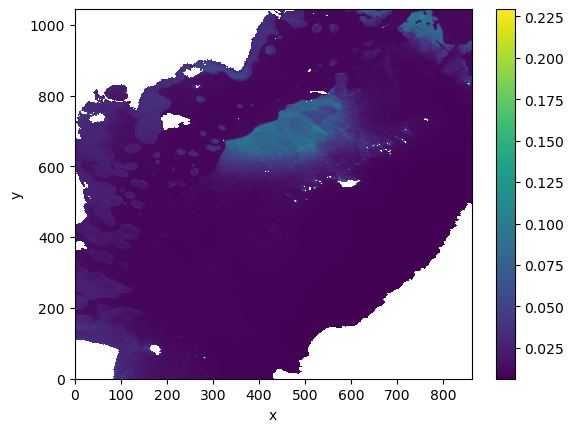

In [121]:
# concert envi file to xarray dataset
import rasterio
import xarray as xa

def envi_to_xarray(envi_fp):
    # Open the ENVI file using rasterio
    with rasterio.open(envi_fp) as src:
        # Read the raster data into a numpy array
        data = src.read()

        # Get the coordinates (band, y, x) for xarray Dataset
        bands = np.arange(1, data.shape[0] + 1)  # Assuming bands are sequentially numbered
        # y_coords, x_coords = src.indexes[1], src.indexes[2]  # Rasterio treats as (band, row, column)

        # Create the xarray Dataset
        dataset = xa.DataArray(
            data=data,
            dims=("band", "y", "x"),
            coords={
                "band": bands,
                "y": np.arange(src.height),
                "x": np.arange(src.width)
            },
            attrs=src.meta  # Add metadata from the ENVI file
        )

    return dataset

mask_xa = envi_to_xarray(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(scene_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
scene_xa = envi_to_xarray(corr_fp)
masked_scene_xa = scene_xa.where(mask_xa == 1, np.nan)

# visualise data
mean_scene_xa = masked_scene_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

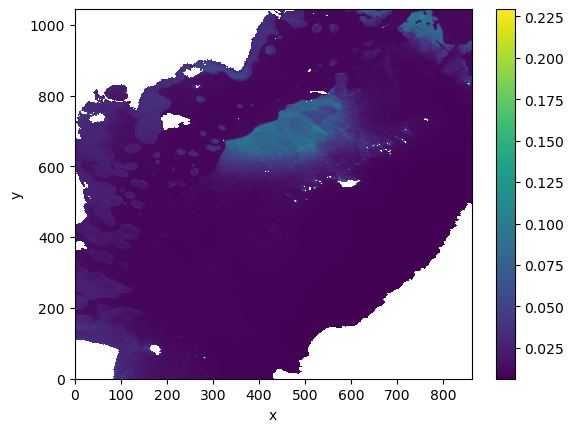

In [131]:
# trim_scene = masked_scene_xa.isel(y=slice(400,500), x=slice(400,500))
trim_scene = masked_scene_xa
trim_scene_vals = trim_scene.values.reshape(trim_scene.shape[0], -1)
trim_scene.median(dim="band", skipna=True).plot.imshow()

In [141]:
trim_scene_vals.T

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.07284708, -0.04595187,  0.03249984, ...,  0.00952412,
         0.01075277,  0.01014481],
       [-0.06882763, -0.04624782,  0.03891028, ...,  0.00950593,
         0.00900921,  0.00978429],
       [-0.07139423, -0.04669501,  0.03607563, ...,  0.00990617,
         0.01050236,  0.01024818]], dtype=float32)

In [139]:
wvs = hs_corrected_metadata.bands.centers
subset_vals = pd.DataFrame(trim_scene_vals.T, columns=wvs)
subset_vals.head()

,350.718109,353.548370,356.378662,359.209045,362.039459,364.869934,367.700500,370.531067,373.361725,376.192444,...,1020.218201,1023.061768,1025.905273,1028.749023,1031.592651,1034.436401,1037.280273,1040.124146,1042.968018,1045.812012
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
rgb_vals = plotting.generate_spectra_color(subset_vals, vis_percentiles=(5, 95))

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/plotting.py:85: RuntimeWarning: Mean of empty slice
  red_vals = np.nanmean(spectra[:, red_mask], axis=1)
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/plotting.py:86: RuntimeWarning: Mean of empty slice
  green_vals = np.nanmean(spectra[:, green_mask], axis=1)
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/plotting.py:87: RuntimeWarning: Mean of empty slice
  blue_vals = np.nanmean(spectra[:, blue_mask], axis=1)


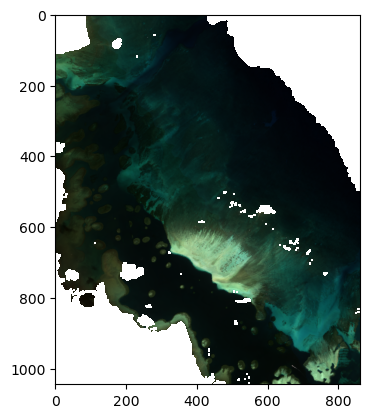

In [158]:
# plot, taking band values as RGB values
vis_percentiles=(5, 95)
plt.imshow(rgb_vals.reshape(trim_scene.shape[1], trim_scene.shape[2], 3))